# git clone & install packages

In [1]:
!pip install -q matplotlib
!pip install -q nflows==0.14
# !pip install -q pandas==2.0.3
!pip install -q prdc==0.2
!pip install -q protobuf==4.23.4
!pip install -q pytorch-fid==0.2.1
!pip install -q tensorboardx==2.6.2
!pip install -q h5py==3.9.0
!pip install -U tensorboard-plugin-profile
!pip install vocos
!pip install scandir
import IPython
from vocos import Vocos
import numpy as np

In [2]:
# Attach Drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/PatRecProj/UoMH')

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/SteliosZ1312/patrec_project ./UoMH/
# # import os
# # os.chdir('/content/UoMH')

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

# Generate Dataset

In [ ]:
os.chdir('/content/drive/MyDrive/PatRecProj')
os.getcwd()

'/content/drive/MyDrive/PatRecProj'

## New Section

In [ ]:
!rm -r UoMH/data/audio-mnist/spectrograms/test

In [ ]:
!rm -r UoMH/data/audio-mnist/spectrograms/train

In [ ]:
!mkdir UoMH/data/audio-mnist/spectrograms/test
!mkdir UoMH/data/audio-mnist/spectrograms/train

In [ ]:
!pip install scandir
!pip install speedcopy
from scandir import scandir, walk
import speedcopy

In [ ]:
import shutil
dataset_dir = 'audio-mnist/spectrograms'
train_dest = 'UoMH/data/audio-mnist/spectrograms/train'
test_dest = 'UoMH/data/audio-mnist/spectrograms/test'
i = 0
for root, _, file_names in walk(dataset_dir):
    # print(len(file_names))
    for file_name in file_names:

        label = int(file_name[0])
        speaker = int(file_name[2:4])

        file_path = os.path.join(root, file_name)

        print(file_path)
        if speaker in [1,2,3,4,5,6,7,8,9,10]:
          i +=1
          print(speaker, i, "train")
          shutil.copy(file_path, train_dest)
        elif speaker in [11,12,13,14]:
          i +=1
          print(speaker, i, "test")
          shutil.copy(file_path, test_dest)

In [ ]:
num_entries = sum(1 for _ in os.scandir(train_dest))
print("Number of entries:", num_entries)

Number of entries: 5000


In [ ]:
!zip -r UoMH.zip UoMH

# Train VAE

In [ ]:
os.chdir('/content/drive/MyDrive/PatRecProj/UoMH')

In [ ]:
!python ./single_main.py --dataset audio-mnist --model vae --is-gae --run-name audio_5k

# Generate sample

In [4]:
from load_run import load_single_module

run_dir = r"runs/audio_5k"

vae = load_single_module(run_dir)

Missing keys in module: [] Unexpected keys in module: []
Loaded vae checkpoint `latest' after epoch 100


In [6]:
for batch in vae['train_loader']:
  print(batch)
  break

In [7]:
batch[1]

tensor([3, 7, 8, 2, 0, 3, 6, 0, 4, 5, 8, 4, 2, 7, 5, 8, 1, 9, 2, 2, 2, 9, 3, 2,
        4, 3, 0, 8, 8, 4, 4, 2, 0, 5, 0, 9, 6, 7, 9, 5, 6, 1, 8, 9, 3, 5, 3, 5,
        0, 7, 9, 1, 8, 3, 7, 5, 4, 1, 7, 5, 8, 0, 7, 4], device='cuda:0')

In [8]:
batch[0].shape

torch.Size([64, 1, 100, 64])

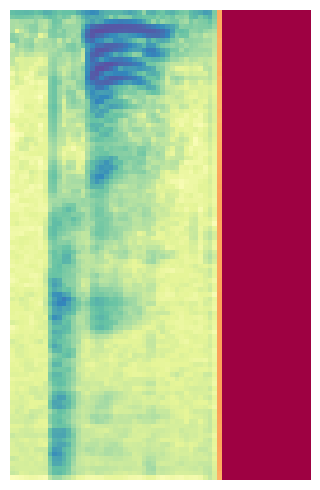

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))  # 2 rows, 4 columns


image = batch[0][2][0].cpu().detach().numpy()
plt.imshow(image,cmap='Spectral')
plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

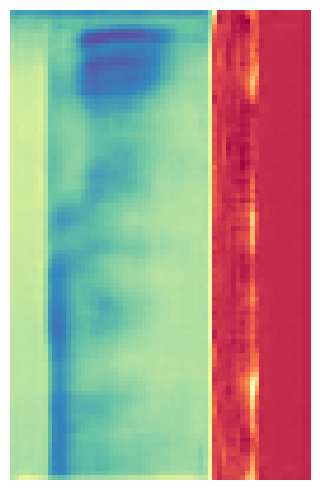

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
n_samples = 1

sample = vae['module'].sample(n_samples,  true_sample=False)

fig, axes = plt.subplots(figsize=(10, 5))  # 2 rows, 4 columns


image = sample.cpu().detach().numpy()[0,0]
plt.imshow(image,cmap='Spectral')
plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
sample = sample[0].cpu()
audio = vocos.decode(sample)
IPython.display.Audio(audio, rate=22050)

In [ ]:
from scipy.io.wavfile import write

# Create waveform.
rate = 22050  # Sampling rate [samples/s].

# Save audio file (range of s is [-1, 1]).
write('four.wav', rate, audio[0].numpy()*100)

In [ ]:
audio[0]*np.iinfo(np.int16).max

tensor([ 1.2861e+01,  1.3643e+01,  1.3211e+01,  ..., -1.3432e-06,
         1.5291e-05,  4.0392e-06])

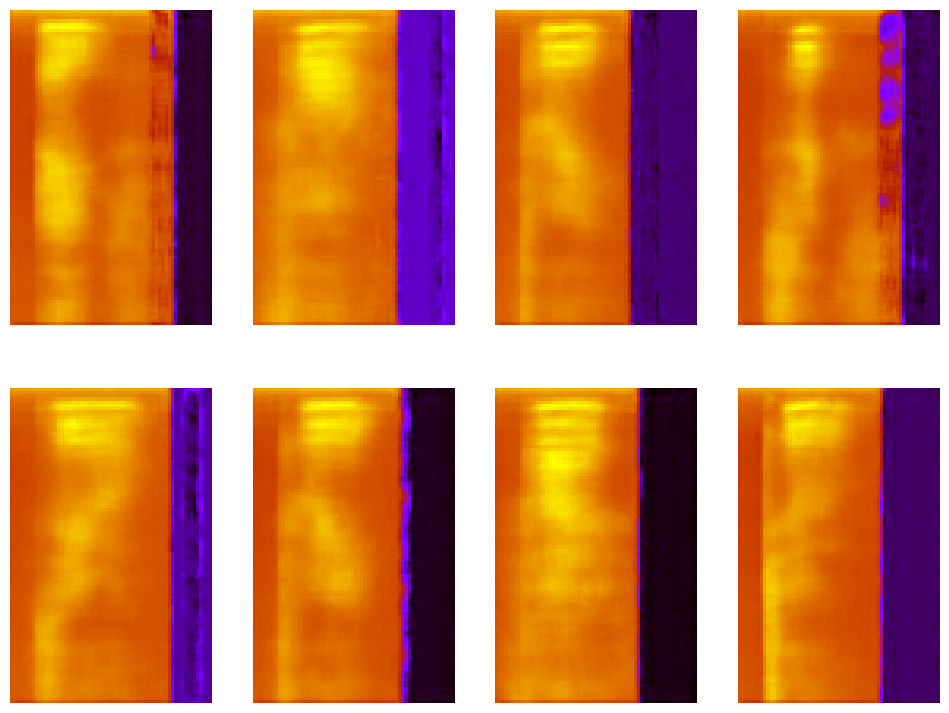

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
n_samples = 8

samples = vae['module'].sample(n_samples,  true_sample=False)

fig, axes = plt.subplots(2, 4, figsize=(12, 9))  # 2 rows, 4 columns

for i, ax in enumerate(axes.flatten()):
    image = samples.cpu().detach().numpy()[i, 0]
    ax.imshow(image, cmap='gnuplot')
    ax.axis('off')  # Turn off axis labels
 # Adjust layout to prevent overlap
plt.show()

In [ ]:
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
sample = sample[0].cpu()
audio = vocos.decode(sample)
IPython.display.Audio(audio, rate=22050)

# D-VAE

## Train d-vae

In [ ]:
!python ./single_cluster_main.py --dataset audio-mnist --model vae --is-gae --run-name dvae/mnist

# Test D-VAE

In [ ]:
!python ./single_cluster_main.py --dataset audio-mnist --model vae --is-gae --run-name dvae